<a href="https://colab.research.google.com/github/mddsayemm/Precision-Farming/blob/main/FinalTestComp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-8-7fa90f9ae71f>:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
Testing Progress: 100%|██████████| 29/29 [02:0

Test results saved to: /content/drive/MyDrive/test_results.csv


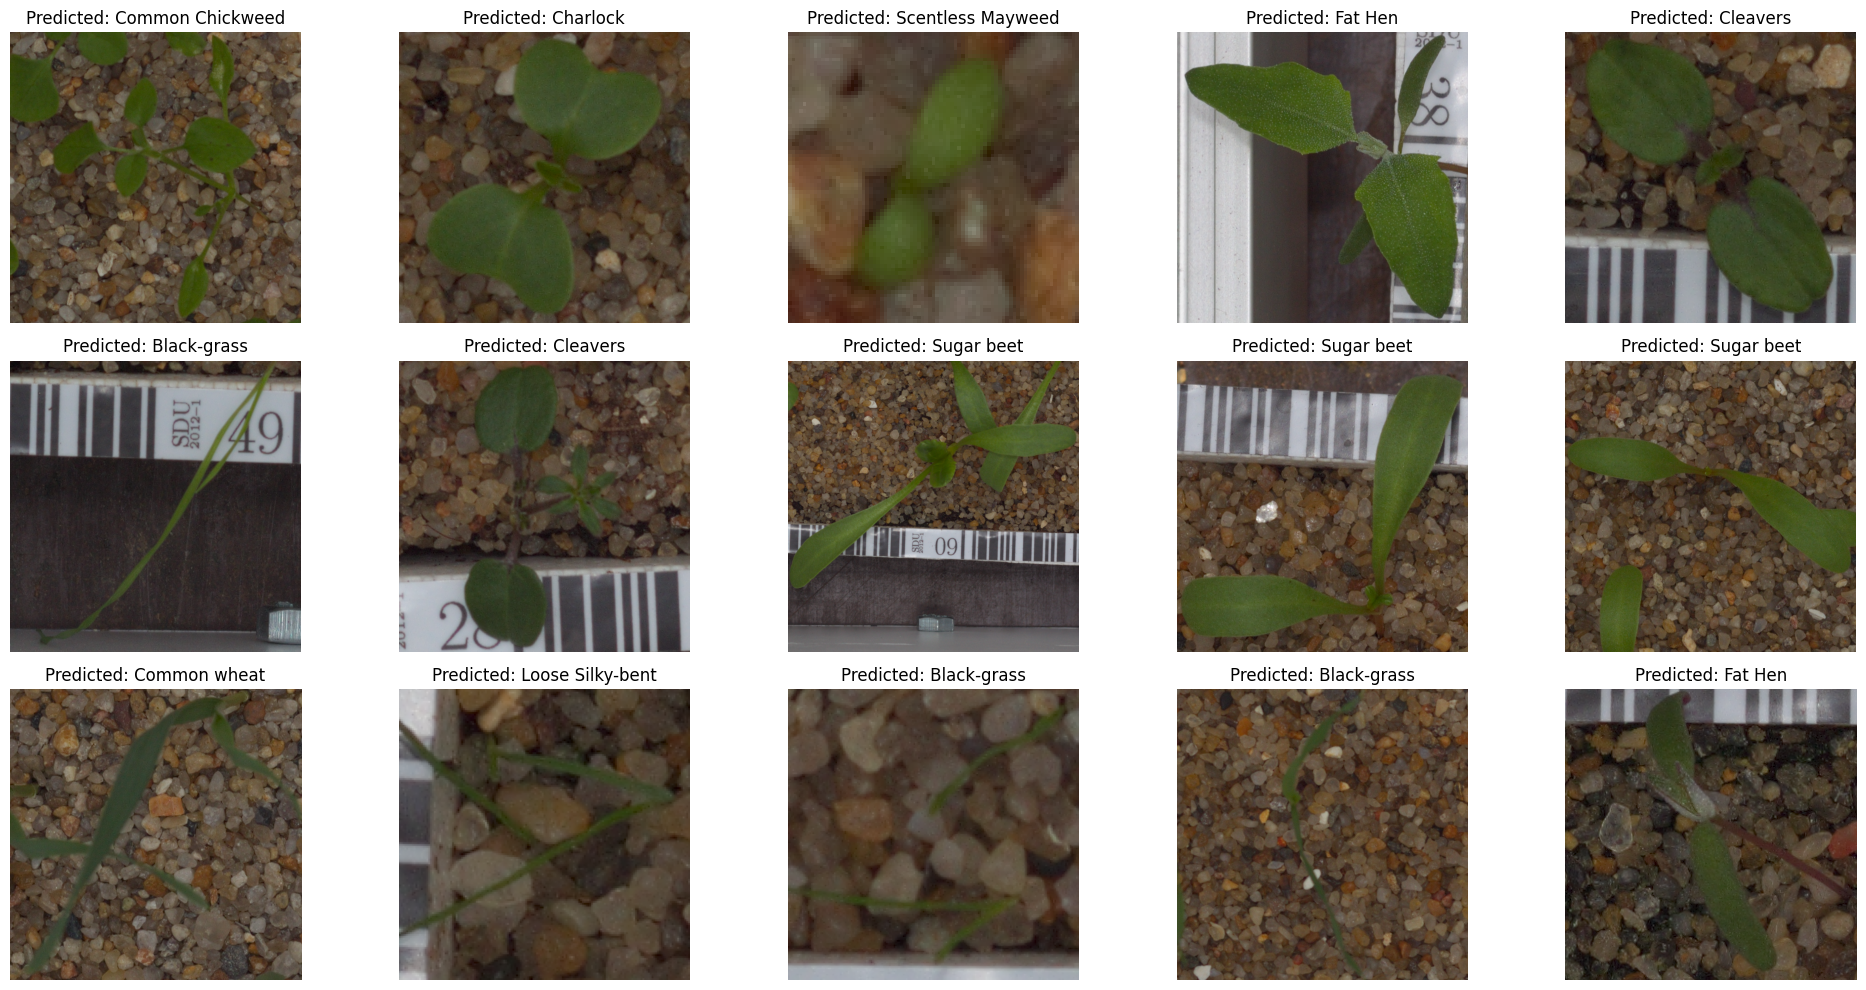

In [8]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
import random
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# Path to your dataset folder
dataset_path = "/content/drive/MyDrive/ProcessedDataset"

# Ensure the dataset folder exists
assert os.path.exists(dataset_path), "Dataset folder does not exist!"

# Custom Dataset for Loading Images Without Classes
class CustomImageDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.image_paths = [
            os.path.join(folder_path, fname)
            for fname in os.listdir(folder_path)
            if fname.lower().endswith(('jpg', 'jpeg', 'png'))
        ]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, image_path

# Data transformations (resize and normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Create the custom dataset
test_dataset = CustomImageDataset(dataset_path, transform=transform)

# Create a DataLoader for testing
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the trained model
model_path = "/content/drive/MyDrive/plant_classifier_resnet18.pth"  # Update the path as needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model architecture (match the saved model)
model = models.resnet18(pretrained=False)
num_classes = 12  # Update to match the number of classes used during training
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()

# Class names (update with actual class names used during training)
class_names = [
    'Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen',
    'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherd’s Purse',
    'Small-flowered Cranesbill', 'Sugar beet'
]

# Function to perform inference on the dataset
def evaluate_model_with_names(model, data_loader, device):
    predictions = []
    image_paths = []

    with torch.no_grad():
        for inputs, paths in tqdm(data_loader, desc="Testing Progress"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            predictions.extend(preds.cpu().numpy())
            image_paths.extend(paths)

    return predictions, image_paths

# Evaluate the model on the test dataset
predictions, image_paths = evaluate_model_with_names(model, test_loader, device)

# Create a CSV file with results
output_csv_path = "/content/drive/MyDrive/test_results.csv"  # Update this path if needed

# Prepare data for CSV
results = []
for img_path, pred in zip(image_paths, predictions):
    # Extract the base filename (e.g., 000 from 000.jpg)
    img_name = os.path.splitext(os.path.basename(img_path))[0]
    predicted_class = class_names[pred]
    results.append((img_name, predicted_class))

# Convert to a pandas DataFrame
results_df = pd.DataFrame(results, columns=['Image', 'Class'])

# Save to a CSV file
results_df.to_csv(output_csv_path, index=False)
print(f"Test results saved to: {output_csv_path}")

# Visualize 15 random images with their predictions
def visualize_predictions(image_paths, predictions, class_names, num_images=15):
    plt.figure(figsize=(20, 10))

    # Select 15 random images
    indices = random.sample(range(len(image_paths)), min(num_images, len(image_paths)))

    for i, idx in enumerate(indices):
        img_path = image_paths[idx]
        pred_class = class_names[predictions[idx]]

        # Load and plot the image
        img = Image.open(img_path).convert("RGB")
        plt.subplot(3, 5, i + 1)  # 3 rows, 5 columns
        plt.imshow(img)
        plt.title(f"Predicted: {pred_class}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Call the visualization function
visualize_predictions(image_paths, predictions, class_names)


In [14]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Path to the dataset_mapping.csv file
original_csv_path = "/content/drive/MyDrive/dataset_mapping.csv"  # Update this path
cleaned_csv_path = "/content/drive/MyDrive/dataset_mapping_cleaned.csv"  # Path to save cleaned CSV

# Load the CSV file
original_data = pd.read_csv(original_csv_path)

# Ensure the necessary columns exist
assert 'Image' in original_data.columns, "'Image' column is missing in dataset_mapping.csv!"
assert 'Class' in original_data.columns, "'Class' column is missing in dataset_mapping.csv!"

# Clean the 'Image' column to retain only the numeric portion (e.g., "000" from "000 Black-grass")
original_data['Image'] = original_data['Image'].str.extract(r'(\d+)', expand=False)

# Debug: Check the cleaned DataFrame
print("Cleaned Data Sample:")
print(original_data.head())

# Save the cleaned DataFrame to a new CSV file
original_data.to_csv(cleaned_csv_path, index=False)
print(f"Cleaned dataset saved to: {cleaned_csv_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Cleaned Data Sample:
  Image              Class
0   000        Black-grass
1   001        Black-grass
2   002        Black-grass
3   003   Loose Silky-bent
4   004  Scentless Mayweed
Cleaned dataset saved to: /content/drive/MyDrive/dataset_mapping_cleaned.csv


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Testing Accuracy: 95.67%


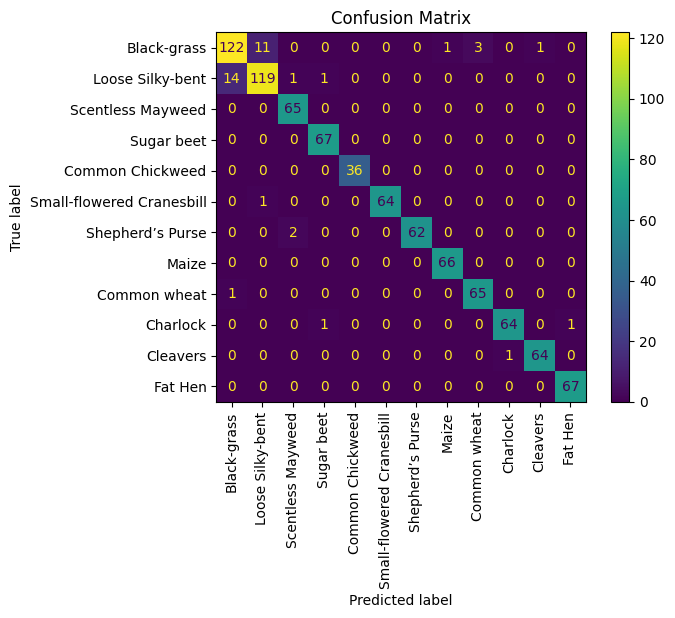

In [16]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Paths to the CSV files
original_csv_path = "/content/drive/MyDrive/dataset_mapping_cleaned.csv"  # Update this path
test_csv_path = "/content/drive/MyDrive/test_results.csv"         # Update this path

# Load the CSV files
original_data = pd.read_csv(original_csv_path)
test_results = pd.read_csv(test_csv_path)

# Ensure both CSVs have the necessary structure
assert 'Image' in original_data.columns, "'Image' column is missing in dataset_mapping.csv!"
assert 'Class' in original_data.columns, "'Class' column is missing in dataset_mapping.csv!"
assert 'Image' in test_results.columns, "'Image' column is missing in test_results.csv!"
assert 'Class' in test_results.columns, "'Class' column is missing in test_results.csv!"

# Merge the two DataFrames on the 'Image' column to align original and predicted labels
merged_data = pd.merge(original_data, test_results, on='Image', suffixes=('_Original', '_Predicted'))

# Extract original and predicted class labels
original_classes = merged_data['Class_Original']
predicted_classes = merged_data['Class_Predicted']

# Calculate accuracy
accuracy = accuracy_score(original_classes, predicted_classes)
print(f"Testing Accuracy: {accuracy * 100:.2f}%")

# Generate and plot the confusion matrix
cm = confusion_matrix(original_classes, predicted_classes, labels=original_classes.unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=original_classes.unique())
disp.plot(cmap="viridis", xticks_rotation="vertical")
plt.title("Confusion Matrix")
plt.show()
